****This is a image classification task where I am classifying between 3 types of brain cancer, Menin, Glioma and Tumor.****

This below code directly downloads the data so the reader does not have to go through the hasstle of downloading the data and setting it up for the code.

In [48]:
import os

# Install gdown if you haven't already
!pip install gdown

# Replace 'YOUR_FILE_ID_FOR_THE_ZIP' with the actual ID you copied
file_id = '10w2Lkl_se2ApcFq3m-yg_c1S9pWHutmy'
output_filename = 'brain_cancer_image_dataset.zip' # Give it a meaningful name

!gdown {file_id} -O {output_filename}

if not os.path.exists("/content/Data_folder"):
  os.makedirs("/content/Data_folder")

# Unzip the file
!unzip {output_filename} -d /content/Data_folder # Choose your desired destination folder
# -d flag specifies the directory to extract to. Create it if needed: !mkdir /content/Data_folder

Downloading...
From (original): https://drive.google.com/uc?id=10w2Lkl_se2ApcFq3m-yg_c1S9pWHutmy
From (redirected): https://drive.google.com/uc?id=10w2Lkl_se2ApcFq3m-yg_c1S9pWHutmy&confirm=t&uuid=26cbb0a7-ef8b-4bf1-9941-06e6e3a4feb1
To: /kaggle/working/brain_cancer_image_dataset.zip
100%|█████████████████████████████████████████| 152M/152M [00:00<00:00, 191MB/s]
Archive:  brain_cancer_image_dataset.zip
replace /content/Data_folder/Brain Cancer Dataset/Brain_Cancer/brain_glioma/brain_glioma_0001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


Installing the which libraries which is not preinstalled in colab

In [49]:
!pip install torchinfo

Let's Import the required libraries.

In [50]:
import os
import sys
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchinfo
from PIL import Image
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, ConcatDataset, Subset, random_split
from torchinfo import summary
from torchvision import datasets, transforms, models
from tqdm.notebook import tqdm

Setting up our device so that we can use the GPU

In [51]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(f"Using {device} device.")

Using cuda device.


Setting up the data directory and get the labels for our data.

In [52]:
data_dir = "/content/Data_folder/Brain Cancer Dataset/Brain_Cancer"
labels = os.listdir(data_dir)
labels

['brain_tumor', 'brain_menin', 'brain_glioma']

As we can see there are three types of images. These are the classes for this project.

Now lets create paths for each of the classe's folders.

In [53]:
brain_menin_path = os.path.join(data_dir, 'brain_menin')
brain_glioma_path = os.path.join(data_dir, 'brain_glioma')
brain_tumor_path = os.path.join(data_dir, 'brain_tumor')

Finding out how many images we have for each class in the dataset.

In [54]:
brain_menin_images = os.listdir(brain_menin_path)
brain_glioma_images = os.listdir(brain_glioma_path)
brain_tumor_images = os.listdir(brain_tumor_path)

In [55]:
print(f"Number of Menin image: {len(brain_menin_images)}")
print(f"Number of Glioma image: {len(brain_glioma_images)}")
print(f"Number of Tumor image: {len(brain_tumor_images)}")

Number of Menin image: 2004
Number of Glioma image: 2004
Number of Tumor image: 2048


As we can see the dataset is quite balanced between the classes.

Now let's go a little deeper and check out how the images look like. We will check out one image for each class. Lets create paths for the first image for each class.

In [56]:
menin_image_name = brain_menin_images[0]
print(menin_image_name)

menin_image_path = os.path.join(brain_menin_path, menin_image_name)
print(menin_image_path)


glioma_image_name = brain_glioma_images[0]
print(glioma_image_name)

glioma_image_path = os.path.join(brain_glioma_path, glioma_image_name)
print(glioma_image_path)


tumor_image_name = brain_tumor_images[0]
print(tumor_image_name)

tumor_image_path = os.path.join(brain_tumor_path, tumor_image_name)
print(tumor_image_path)

brain_menin_0856.jpg
/content/Data_folder/Brain Cancer Dataset/Brain_Cancer/brain_menin/brain_menin_0856.jpg
brain_glioma_1042.jpg
/content/Data_folder/Brain Cancer Dataset/Brain_Cancer/brain_glioma/brain_glioma_1042.jpg
brain_tumor_1448.jpg
/content/Data_folder/Brain Cancer Dataset/Brain_Cancer/brain_tumor/brain_tumor_1448.jpg


We will use Python Imaging Library to load the images.

In [57]:
menin_image_pil = Image.open(menin_image_path)
print("Blank image: ", menin_image_pil.mode, menin_image_pil.size)

glioma_image_pil = Image.open(glioma_image_path)
print("Hog image: ", glioma_image_pil.mode, glioma_image_pil.size)

tumor_image_pil = Image.open(tumor_image_path)
print("Blank image: ", tumor_image_pil.mode, tumor_image_pil.size)

Blank image:  RGB (512, 512)
Hog image:  RGB (512, 512)
Blank image:  RGB (512, 512)


As we can see the images are all RGB images of size 512*512 piexls.

Lets view all three images from each classes.

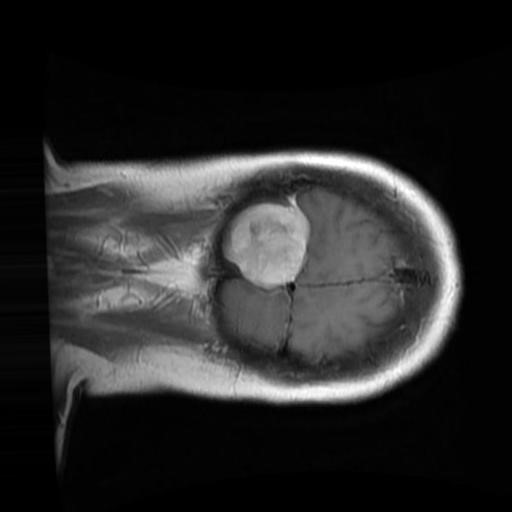

In [58]:
menin_image_pil

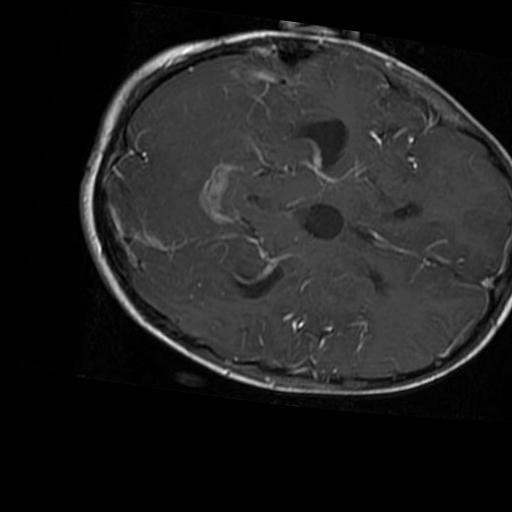

In [59]:
glioma_image_pil

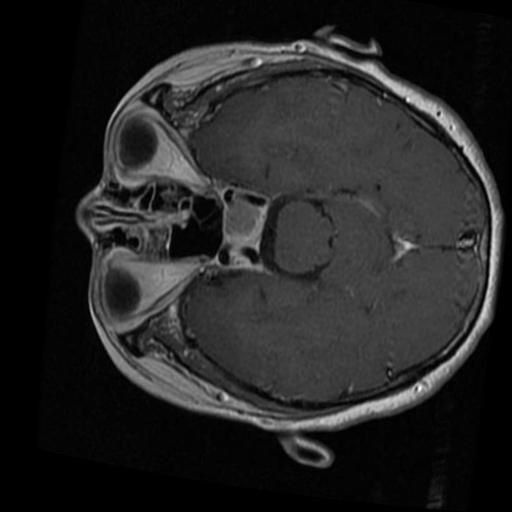

In [60]:
tumor_image_pil

Lets create a callable class which will convert all the non-RGB images into RGB images. If there is some grayscale image in our data, the function will turn that into a 3 channel grayscale image to match the dimention of the RGB image. Basically same image coppied into three channel.

In [61]:
class ConvertToRGB:
    def __call__(self, img):
        return img.convert("RGB")

We will use the ConvertToRGB function along with other transformations. We will change the image into an RGB image (if not already). Then resize it as 224*224 image. Then turn it into a PyTorch tensor. transforms.ToTensor() also scales all the values in the tensor between [0,1].

This is our primary level transformation. We will come to this latter on to apply Normalization.

In [62]:
# Transformations to apply to the images
transform = transforms.Compose(
    [
        ConvertToRGB(),
        transforms.Resize((256, 256)),
        transforms.CenterCrop((224, 224)),
        transforms.ToTensor()
    ]
)

print(type(transform))
print(transform)

<class 'torchvision.transforms.transforms.Compose'>
Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
)


Torchvision datasets.ImageFolder class makes it very easy to work with data if arranged in folders. Lets crteate a dataset object using this.

In [63]:
# Load the dataset using `ImageFolder`
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
print(dataset)

Dataset ImageFolder
    Number of datapoints: 6056
    Root location: /content/Data_folder/Brain Cancer Dataset/Brain_Cancer
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(224, 224))
               ToTensor()
           )


We can check the classes.

In [64]:
dataset.classes

['brain_glioma', 'brain_menin', 'brain_tumor']

dataset.samples givs us a list of tuple which has file path for the image and label for the image. lets check out all the distinct class labels

In [65]:
im = dataset.samples
print(im[0])

distinct_classes = {x[1] for x in im}
print(distinct_classes)

('/content/Data_folder/Brain Cancer Dataset/Brain_Cancer/brain_glioma/brain_glioma_0001.jpg', 0)
{0, 1, 2}


Lets create a class to index mapping as it will be required for class counting for our subsets

In [66]:
class_to_idx_mapping = dataset.class_to_idx
class_to_idx_mapping

{'brain_glioma': 0, 'brain_menin': 1, 'brain_tumor': 2}

We want to calculate mean and std for the images across 3 channels so that we can use it to Normalize the images. To do that we will create a data loader object of our dataset and then use a custom function to calculate mean and std.

Lets create the dataloader object

In [67]:
dataloader = DataLoader(dataset, 32)

Let's create a function which will calculate the mean and std of the images. This function takes a dataloader object and returns mean and std along 3 channels of the images.

In [68]:
def get_mean_std(loader):
    """Computes the mean and standard deviation of image data.

    Input: a `DataLoader` producing tensors of shape [batch_size, channels, pixels_x, pixels_y]
    Output: the mean of each channel as a tensor, the standard deviation of each channel as a tensor
            formatted as a tuple (means[channels], std[channels])"""

    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in tqdm(loader, desc="Computing mean and std", leave=False):
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1
    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean**2) ** 0.5

    return mean, std

Now lets compute the mean and std of the images along 3 channels for all of our dataset.

In [69]:
mean, std = get_mean_std(dataloader)
print(f"Mean across 3 channels R G B: {mean}")
print(f"Standard Deviation across 3 channels R G B: {std}")

Computing mean and std:   0%|          | 0/190 [00:00<?, ?it/s]

Mean across 3 channels R G B: tensor([0.1898, 0.1898, 0.1898])
Standard Deviation across 3 channels R G B: tensor([0.1732, 0.1732, 0.1732])


Now We will use **data augmentation**. To do that lets create a new function which will take our whole dataset and retun train, validation and test data loader objects. We will specify also use the split ratios in here.

Lets create a function using which we can apply transformations directly to the substes of the data.

In [70]:
class TransformedSubsetDataset(torch.utils.data.Dataset):
    def __init__(self, subset: Subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        img, label = self.subset.dataset[self.subset.indices[idx]]
        if self.transform:
            img = self.transform(img)
        return img, label

Now lets create our augmentation function

In [ ]:
# Augmentation Function
def subset_dataset(root_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, data_augmentation=False, random_seed=42):
    # Ensure ratios sum to 1 (approximately)
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6

    # Define transforms
    # Transform for validation and test sets (and base training set if not augmented)
    transform_eval = transforms.Compose([
        ConvertToRGB(),
        transforms.Resize((256, 256)),
        transforms.CenterCrop((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    # Augmentation transform 1 (random crop + flip)
    transform_aug1 = transforms.Compose([
        ConvertToRGB(),
        transforms.Resize((256, 256)),
        transforms.RandomCrop((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    # Augmentation transform 2 (random crop + rotation)
    transform_aug2 = transforms.Compose([
        ConvertToRGB(),
        transforms.Resize((256, 256)),
        transforms.RandomCrop((224, 224)),
        transforms.RandomRotation(degrees=30, interpolation=Image.BILINEAR),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    full_dataset = datasets.ImageFolder(root=root_dir, transform=None)

    # Get indices and labels for stratified splitting
    all_indices = list(range(len(full_dataset)))
    all_labels = np.array([s[1] for s in full_dataset.samples])

    # First, split into train_val_indices and test_indices
    train_val_indices, test_indices, _, _ = train_test_split(
        all_indices, all_labels,
        test_size=test_ratio,
        stratify=all_labels,
        random_state=random_seed
    )

    # Then, split train_val_indices into train_indices and val_indices
    relative_val_ratio = val_ratio / (train_ratio + val_ratio)
    train_indices, val_indices, _, _ = train_test_split(
        train_val_indices, all_labels[np.array(train_val_indices)],
        test_size=relative_val_ratio,
        stratify=all_labels[np.array(train_val_indices)],
        random_state=random_seed
    )

    # Then, create the subsets of the full dataset
    base_train_subset = Subset(full_dataset, train_indices)
    base_val_subset = Subset(full_dataset, val_indices)
    base_test_subset = Subset(full_dataset, test_indices)

    # 4. Wrap Subsets with TransformedSubsetDataset to apply specific transforms
    val_set = TransformedSubsetDataset(base_val_subset, transform=transform_eval)
    test_set = TransformedSubsetDataset(base_test_subset, transform=transform_eval)

    if data_augmentation:
        train_set_original = TransformedSubsetDataset(base_train_subset, transform=transform_eval)
        aug1_train_set = TransformedSubsetDataset(base_train_subset, transform=transform_aug1)
        aug2_train_set = TransformedSubsetDataset(base_train_subset, transform=transform_aug2)

        # Concatenate all training sets
        train_set = ConcatDataset([train_set_original, aug1_train_set, aug2_train_set])
    else:
        # If no augmentation, just use the standard transform for the training set
        train_set = TransformedSubsetDataset(base_train_subset, transform=transform_eval)

    return train_set, val_set, test_set

First we will use Normal splits to train our model. Then we will use Augmened training dataset to train our model and see if we get any improvements.

Lets get our Normal train, val and test sets

In [72]:
train_set, val_set, test_set = subset_dataset(data_dir, 0.7, 0.2, 0.1)

In [73]:
print(f"Length of training set: {len(train_set)}")
print(f"Length of validation set: {len(val_set)}")
print(f"Length of test set: {len(test_set)}")

Length of training set: 4238
Length of validation set: 1212
Length of test set: 606


lets create a function which will count for the classses in each of the datasets. this function returns a pandas series where the indices are the classes and values are the respective count for each class.

In [74]:
def class_counts(dataset, class_to_index):
    if isinstance(dataset, ConcatDataset):
        all_labels = []
        for sub_dataset in dataset.datasets:
            for idx_in_sub in range(len(sub_dataset)):
                global_idx = sub_dataset.subset.indices[idx_in_sub]
                all_labels.append(sub_dataset.subset.dataset.samples[global_idx][1])
    else:
        all_labels = [x[1] for x in tqdm(dataset, desc="Counting classes")]

    c = Counter(all_labels)
    return pd.Series({cat: c[idx] for cat, idx in class_to_index.items()})

In [75]:
train_class_count = class_counts(train_set, class_to_idx_mapping)
train_class_count

Counting classes:   0%|          | 0/4238 [00:00<?, ?it/s]

brain_glioma    1402
brain_menin     1403
brain_tumor     1433
dtype: int64

lets plot the class count for our training set.

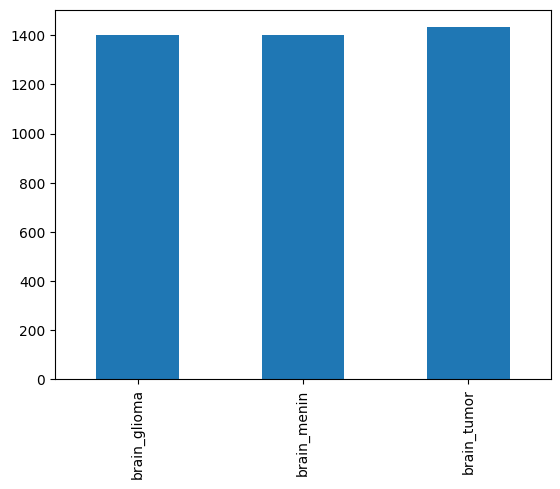

In [76]:
train_class_count.sort_values().plot(kind="bar");

doing the same for the val_dataset

In [77]:
val_class_count = class_counts(val_set, class_to_idx_mapping)
val_class_count

Counting classes:   0%|          | 0/1212 [00:00<?, ?it/s]

brain_glioma    401
brain_menin     401
brain_tumor     410
dtype: int64

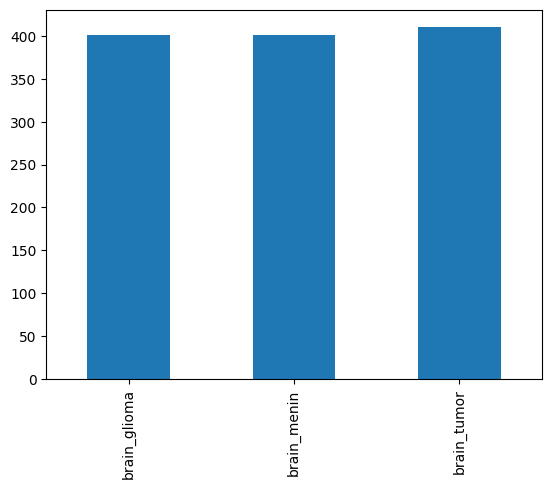

In [78]:
val_class_count.sort_values().plot(kind="bar");

same for test_dataset

In [79]:
test_class_count = class_counts(test_set, class_to_idx_mapping)
test_class_count

Counting classes:   0%|          | 0/606 [00:00<?, ?it/s]

brain_glioma    201
brain_menin     200
brain_tumor     205
dtype: int64

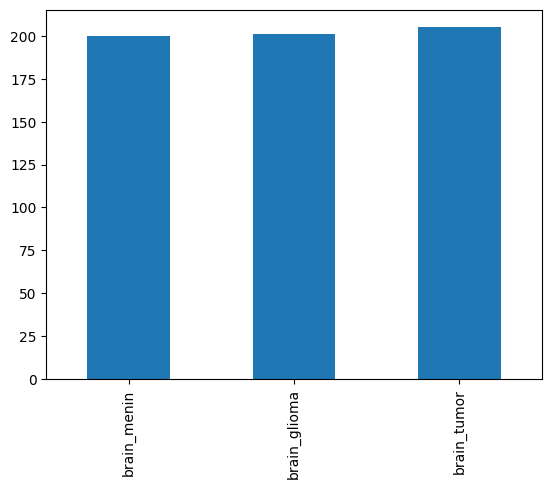

In [80]:
test_class_count.sort_values().plot(kind="bar");

As we can see for the three datasets, we have balanced datasets for all the classes.

Now let's crteate our new DataLoader for each of the normalized datasets. We will use batch size of 32. We will shuffle the training set but not the val or test set.

In [83]:
g = torch.Generator().manual_seed(42)

batch_size = 32

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, generator=g, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, generator=g, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, generator=g, pin_memory=True)

Dataloader creates a iterator. So we can access its items using iter and next function

In [84]:
batch, label = next(iter(train_loader))

Lets inspect this one batch of data and the corresponding labels

In [85]:
print(f'Shape of the batch: {batch.shape}')
print(f'Shape of the label: {label.shape}')

Shape of the batch: torch.Size([32, 3, 224, 224])
Shape of the label: torch.Size([32])


In [86]:
label

tensor([0, 2, 1, 1, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 2, 1, 0, 1, 2, 2, 2, 2, 1,
        0, 1, 1, 2, 0, 2, 1, 2])

As we can see each of the batch has 32 images of size 3x224x224. and the label contains the corresponding labels for those 32 images.

Now lets create a CNN model which will have 3 convolution layers and then 2 dense layers. We will use maxpooling and ReLU as activation function. Also we will use batch normalizations in the conv layers and dropouts in the dense layes. This will contrl overfitting for our model.

In [87]:
class MyCNN(nn.Module):
  def __init__(self, num_channels, num_classes):
    super().__init__()
    self.feature_extractor = nn.Sequential(
        nn.Conv2d(in_channels=num_channels, out_channels=16, kernel_size=2, padding=1),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=2, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=64*28*28, out_features=512),
        nn.ReLU(),
        nn.Dropout(p=0.5),

        nn.Linear(in_features=512, out_features=128),
        nn.ReLU(),
        nn.Dropout(p=0.5),

        nn.Linear(in_features=128, out_features=num_classes)
    )

  def forward(self, x):
    out = self.feature_extractor(x)
    out = self.classifier(out)

    return out

Lets create out model object and load it into device. Also lets create our loss and optimizer. Lets also apply weight decay to apply regularization to our model.

In [88]:
model = MyCNN(num_channels=3, num_classes=3).to(device)

optimizer = optim.Adam(model.parameters(), weight_decay=1e-5)
loss_fn = nn.CrossEntropyLoss()

Now we will create a function whcih runs our model for one epoch. The function takes model, optimizer, loss function, data loader object and device as input  and returns the average training loss for that epoch.

In [89]:
def train_epoch(model, optimizer, loss_fn, data_loader, device="cpu"):
    # We'll report the loss function's average value at the end of the epoch.
    training_loss = 0.0

    # The train method simply sets the model in training mode. No training
    # has happened.
    model.train()

    # We iterate over all batches in the training set to complete one epoch
    for inputs, targets in tqdm(data_loader, desc="Training", leave=False):
        # Sets the gradients to zero. We need to do this every time.
        optimizer.zero_grad()

        # Unpack images (X) and labels (y) from the batch and add those
        # tensors to the specified device.
        inputs = inputs.to(device)
        targets = targets.to(device)

        # We make a forward pass through the network and obtain the logits.
        # With the logits, we can calculate our loss.
        output = model(inputs)
        loss = loss_fn(output, targets)

        # After calculating our loss, we calculate the numerical value of
        # the derivative of our loss function with respect to all the
        # trainable model weights. Once we have the gradients calculated,
        # we let the optimizer take a "step", in other words, update or
        # adjust the model weights.
        loss.backward()
        optimizer.step()

        # We increment the training loss for the current batch
        training_loss += loss.data.item() * inputs.size(0)

    # We calculate the training loss over the completed epoch
    return training_loss / len(data_loader.dataset)

Let's create another function which calculates the accuracy score for each epoch.

This function takes model, data loader object, loss function and device as input and returns average loss and accuracy for one epoch.

In [90]:
def score(model, data_loader, loss_fn, device="cpu"):
    total_loss = 0
    total_correct = 0

    model.eval()
    with torch.no_grad():
        for inputs, targets in tqdm(data_loader, desc="Scoring", leave=False):
            inputs = inputs.to(device)
            output = model(inputs)

            targets = targets.to(device)
            loss = loss_fn(output, targets)
            total_loss += loss.data.item() * inputs.size(0)

            correct = torch.eq(torch.argmax(output, dim=1), targets)
            total_correct += torch.sum(correct).item()

    n_observations = data_loader.batch_size * len(data_loader)
    average_loss = total_loss / n_observations
    accuracy = total_correct / n_observations
    return average_loss, accuracy

We will impliment Callback methods.

-> **Learning Rate Scheduling**: Adjusts the learning rate over time, which can lead  to better model performance.

-> **Early Stopping**: Halts training when the model's performance stops improving, which prevents overfitting. We'll stop if validation loss doesn't improve for at least 5 epochs.

-> **Checkpointing**: Saves the model every time validation loss gets better than in the epoch prior. This allows us to recover the best model once training completes.

In order to use these callbacks, we need to implement them and then update the train function.

For the Learning Rate Scheduling, we'll use **StepLR** from torch.optim. The StepLR scheduler decays the learning rate by multiplicative factor **gamma** every **step_size** epochs.

Lets create the learning rate scheduler.

In [91]:
step_size = 4
gamma = 0.2

scheduler = optim.lr_scheduler.StepLR(
    optimizer,
    step_size=step_size,
    gamma=gamma,
)

Now lets create an Early Stopping function. The function counts for how many epochs the best validation score is not beaten by the current validation score. If the for 5 epochs the best validation score is not beaten, this function will give the signal to stop the training.

In [92]:
def early_stopping(validation_loss, best_val_loss, counter):
    """Function that implements Early Stopping"""

    stop = False

    if validation_loss < best_val_loss:
        counter = 0
    else:
        counter += 1

    # Check if counter is >= patience (5 epochs in our case)
    # Set stop variable accordingly
    if counter >= 5:
        stop = True

    return counter, stop

Lets create another function which will create checkpoints for our model. This function saves the model if validation loss improves in the current epoch. This function requires a path, where the checkpoints will be saved.

In [93]:
def checkpointing(validation_loss, best_val_loss, model, optimizer, save_path):

    if validation_loss < best_val_loss:
        torch.save(
            {
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "loss": best_val_loss,
            },
            save_path,
        )
        print(f"Checkpoint saved with validation loss {validation_loss:.4f}")

Now lets create our main Training function. The function takes model, optimizer, loss function, train data loader, validation data loader, number of epochs we want to train, device, learning rate scheduler, checkpointing path, and early stopping function. The function returns learning_rates, train_losses, val_losses, train_accuracies, val_accuracies, number epoch our model trained before early stopping kicked in.

In [94]:
def train(
    model,
    optimizer,
    loss_fn,
    train_loader,
    val_loader,
    epochs=20,
    device="cpu",
    scheduler=None,
    checkpoint_path=None,
    early_stopping=None,
):
    # Track the model progress over epochs
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    learning_rates = []

    # Create the trackers if needed for checkpointing and early stopping
    best_val_loss = float("inf")
    early_stopping_counter = 0

    print("Model evaluation before start of training...")
    # Test on training set
    train_loss, train_accuracy = score(model, train_loader, loss_fn, device)
    print(f"Training loss before Training: {train_loss:.4f}")
    print(f"Training accuracy before Training: {train_accuracy*100:.4f}%")
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Test on validation set
    validation_loss, validation_accuracy = score(model, val_loader, loss_fn, device)
    print(f"Validation loss before Training: {validation_loss:.4f}")
    print(f"Validation accuracy before Training: {validation_accuracy*100:.4f}%")
    val_losses.append(validation_loss)
    val_accuracies.append(validation_accuracy)

    for epoch in range(1, epochs + 1):
        print("\n")
        print(f"Starting epoch {epoch}/{epochs}")

        # Train one epoch
        train_epoch(model, optimizer, loss_fn, train_loader, device)

        # Evaluate training results
        train_loss, train_accuracy = score(model, train_loader, loss_fn, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Test on validation set
        validation_loss, validation_accuracy = score(model, val_loader, loss_fn, device)
        val_losses.append(validation_loss)
        val_accuracies.append(validation_accuracy)

        print(f"Epoch: {epoch}")
        print(f"Training loss: {train_loss:.4f}")
        print(f"Training accuracy: {train_accuracy*100:.4f}%")
        print(f"Validation loss: {validation_loss:.4f}")
        print(f"Validation accuracy: {validation_accuracy*100:.4f}%")

        # # Log the learning rate and have the scheduler adjust it
        lr = optimizer.param_groups[0]["lr"]
        learning_rates.append(lr)
        if scheduler:
            scheduler.step()

        # Checkpointing saves the model if current model is better than best so far
        if checkpoint_path:
            checkpointing(
                validation_loss, best_val_loss, model, optimizer, checkpoint_path
            )

        # Early Stopping
        if early_stopping:
            early_stopping_counter, stop = early_stopping(
                validation_loss, best_val_loss, early_stopping_counter
            )
            if stop:
                print(f"Early stopping triggered after {epoch} epochs")
                break

        if validation_loss < best_val_loss:
            best_val_loss = validation_loss

    return (
        learning_rates,
        train_losses,
        val_losses,
        train_accuracies,
        val_accuracies,
        epoch,
    )

Now lets train our ann model for 50 epochs and see the results. Also lets lets create a checkpointing path

In [124]:
epochs_to_train = 50
checkpoint_file_path = "LR_model.pth"

In [96]:
train_results = train(
    model,
    optimizer,
    loss_fn,
    train_loader,
    val_loader,
    epochs=epochs_to_train,
    device=device,
    scheduler=scheduler,
    checkpoint_path=checkpoint_file_path,
    early_stopping=early_stopping,
)

(
    learning_rates,
    train_losses,
    valid_losses,
    train_accuracies,
    valid_accuracies,
    epochs,
) = train_results

Model evaluation before start of training...


Scoring:   0%|          | 0/133 [00:00<?, ?it/s]

Training loss before Training: 1.0954
Training accuracy before Training: 32.9417%


Scoring:   0%|          | 0/38 [00:00<?, ?it/s]

Validation loss before Training: 1.0962
Validation accuracy before Training: 32.9770%


Starting epoch 1/50


Training:   0%|          | 0/133 [00:00<?, ?it/s]

Scoring:   0%|          | 0/133 [00:00<?, ?it/s]

Scoring:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 1
Training loss: 0.7074
Training accuracy: 70.6532%
Validation loss: 0.7036
Validation accuracy: 70.9704%
Checkpoint saved with validation loss 0.7036


Starting epoch 2/50


Training:   0%|          | 0/133 [00:00<?, ?it/s]

Scoring:   0%|          | 0/133 [00:00<?, ?it/s]

Scoring:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 2
Training loss: 0.6050
Training accuracy: 75.6109%
Validation loss: 0.6158
Validation accuracy: 74.6711%
Checkpoint saved with validation loss 0.6158


Starting epoch 3/50


Training:   0%|          | 0/133 [00:00<?, ?it/s]

Scoring:   0%|          | 0/133 [00:00<?, ?it/s]

Scoring:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 3
Training loss: 0.5330
Training accuracy: 80.1692%
Validation loss: 0.5531
Validation accuracy: 77.7138%
Checkpoint saved with validation loss 0.5531


Starting epoch 4/50


Training:   0%|          | 0/133 [00:00<?, ?it/s]

Scoring:   0%|          | 0/133 [00:00<?, ?it/s]

Scoring:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 4
Training loss: 0.4703
Training accuracy: 81.7904%
Validation loss: 0.5014
Validation accuracy: 79.3586%
Checkpoint saved with validation loss 0.5014


Starting epoch 5/50


Training:   0%|          | 0/133 [00:00<?, ?it/s]

Scoring:   0%|          | 0/133 [00:00<?, ?it/s]

Scoring:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 5
Training loss: 0.4096
Training accuracy: 83.9521%
Validation loss: 0.4630
Validation accuracy: 80.9211%
Checkpoint saved with validation loss 0.4630


Starting epoch 6/50


Training:   0%|          | 0/133 [00:00<?, ?it/s]

Scoring:   0%|          | 0/133 [00:00<?, ?it/s]

Scoring:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 6
Training loss: 0.3999
Training accuracy: 83.6701%
Validation loss: 0.4778
Validation accuracy: 78.8651%


Starting epoch 7/50


Training:   0%|          | 0/133 [00:00<?, ?it/s]

Scoring:   0%|          | 0/133 [00:00<?, ?it/s]

Scoring:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 7
Training loss: 0.3572
Training accuracy: 86.3252%
Validation loss: 0.4522
Validation accuracy: 81.9901%
Checkpoint saved with validation loss 0.4522


Starting epoch 8/50


Training:   0%|          | 0/133 [00:00<?, ?it/s]

Scoring:   0%|          | 0/133 [00:00<?, ?it/s]

Scoring:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 8
Training loss: 0.2888
Training accuracy: 89.4502%
Validation loss: 0.3902
Validation accuracy: 84.7862%
Checkpoint saved with validation loss 0.3902


Starting epoch 9/50


Training:   0%|          | 0/133 [00:00<?, ?it/s]

Scoring:   0%|          | 0/133 [00:00<?, ?it/s]

Scoring:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 9
Training loss: 0.2702
Training accuracy: 90.8365%
Validation loss: 0.3819
Validation accuracy: 85.0329%
Checkpoint saved with validation loss 0.3819


Starting epoch 10/50


Training:   0%|          | 0/133 [00:00<?, ?it/s]

Scoring:   0%|          | 0/133 [00:00<?, ?it/s]

Scoring:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 10
Training loss: 0.2556
Training accuracy: 90.7425%
Validation loss: 0.3685
Validation accuracy: 85.7730%
Checkpoint saved with validation loss 0.3685


Starting epoch 11/50


Training:   0%|          | 0/133 [00:00<?, ?it/s]

Scoring:   0%|          | 0/133 [00:00<?, ?it/s]

Scoring:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 11
Training loss: 0.2471
Training accuracy: 91.4709%
Validation loss: 0.3665
Validation accuracy: 85.9375%
Checkpoint saved with validation loss 0.3665


Starting epoch 12/50


Training:   0%|          | 0/133 [00:00<?, ?it/s]

Scoring:   0%|          | 0/133 [00:00<?, ?it/s]

Scoring:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 12
Training loss: 0.2361
Training accuracy: 91.7058%
Validation loss: 0.3659
Validation accuracy: 85.8553%
Checkpoint saved with validation loss 0.3659


Starting epoch 13/50


Training:   0%|          | 0/133 [00:00<?, ?it/s]

Scoring:   0%|          | 0/133 [00:00<?, ?it/s]

Scoring:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 13
Training loss: 0.2266
Training accuracy: 92.0113%
Validation loss: 0.3538
Validation accuracy: 86.5954%
Checkpoint saved with validation loss 0.3538


Starting epoch 14/50


Training:   0%|          | 0/133 [00:00<?, ?it/s]

Scoring:   0%|          | 0/133 [00:00<?, ?it/s]

Scoring:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 14
Training loss: 0.2242
Training accuracy: 92.2227%
Validation loss: 0.3509
Validation accuracy: 86.9243%
Checkpoint saved with validation loss 0.3509


Starting epoch 15/50


Training:   0%|          | 0/133 [00:00<?, ?it/s]

Scoring:   0%|          | 0/133 [00:00<?, ?it/s]

Scoring:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 15
Training loss: 0.2211
Training accuracy: 92.4107%
Validation loss: 0.3491
Validation accuracy: 86.5132%
Checkpoint saved with validation loss 0.3491


Starting epoch 16/50


Training:   0%|          | 0/133 [00:00<?, ?it/s]

Scoring:   0%|          | 0/133 [00:00<?, ?it/s]

Scoring:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 16
Training loss: 0.2185
Training accuracy: 92.3872%
Validation loss: 0.3491
Validation accuracy: 86.2664%


Starting epoch 17/50


Training:   0%|          | 0/133 [00:00<?, ?it/s]

Scoring:   0%|          | 0/133 [00:00<?, ?it/s]

Scoring:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 17
Training loss: 0.2182
Training accuracy: 92.2932%
Validation loss: 0.3482
Validation accuracy: 86.4309%
Checkpoint saved with validation loss 0.3482


Starting epoch 18/50


Training:   0%|          | 0/133 [00:00<?, ?it/s]

Scoring:   0%|          | 0/133 [00:00<?, ?it/s]

Scoring:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 18
Training loss: 0.2172
Training accuracy: 92.3402%
Validation loss: 0.3478
Validation accuracy: 86.6776%
Checkpoint saved with validation loss 0.3478


Starting epoch 19/50


Training:   0%|          | 0/133 [00:00<?, ?it/s]

Scoring:   0%|          | 0/133 [00:00<?, ?it/s]

Scoring:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 19
Training loss: 0.2177
Training accuracy: 92.3637%
Validation loss: 0.3489
Validation accuracy: 86.5132%


Starting epoch 20/50


Training:   0%|          | 0/133 [00:00<?, ?it/s]

Scoring:   0%|          | 0/133 [00:00<?, ?it/s]

Scoring:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 20
Training loss: 0.2151
Training accuracy: 92.1992%
Validation loss: 0.3477
Validation accuracy: 86.6776%
Checkpoint saved with validation loss 0.3477


Starting epoch 21/50


Training:   0%|          | 0/133 [00:00<?, ?it/s]

Scoring:   0%|          | 0/133 [00:00<?, ?it/s]

Scoring:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 21
Training loss: 0.2173
Training accuracy: 92.4342%
Validation loss: 0.3489
Validation accuracy: 86.1842%


Starting epoch 22/50


Training:   0%|          | 0/133 [00:00<?, ?it/s]

Scoring:   0%|          | 0/133 [00:00<?, ?it/s]

Scoring:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 22
Training loss: 0.2165
Training accuracy: 92.4342%
Validation loss: 0.3483
Validation accuracy: 86.1020%


Starting epoch 23/50


Training:   0%|          | 0/133 [00:00<?, ?it/s]

Scoring:   0%|          | 0/133 [00:00<?, ?it/s]

Scoring:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 23
Training loss: 0.2153
Training accuracy: 92.2462%
Validation loss: 0.3478
Validation accuracy: 86.6776%


Starting epoch 24/50


Training:   0%|          | 0/133 [00:00<?, ?it/s]

Scoring:   0%|          | 0/133 [00:00<?, ?it/s]

Scoring:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 24
Training loss: 0.2155
Training accuracy: 92.3637%
Validation loss: 0.3466
Validation accuracy: 86.5954%
Checkpoint saved with validation loss 0.3466


Starting epoch 25/50


Training:   0%|          | 0/133 [00:00<?, ?it/s]

Scoring:   0%|          | 0/133 [00:00<?, ?it/s]

Scoring:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 25
Training loss: 0.2159
Training accuracy: 92.3872%
Validation loss: 0.3476
Validation accuracy: 87.0888%


Starting epoch 26/50


Training:   0%|          | 0/133 [00:00<?, ?it/s]

Scoring:   0%|          | 0/133 [00:00<?, ?it/s]

Scoring:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 26
Training loss: 0.2154
Training accuracy: 92.3402%
Validation loss: 0.3470
Validation accuracy: 86.4309%


Starting epoch 27/50


Training:   0%|          | 0/133 [00:00<?, ?it/s]

Scoring:   0%|          | 0/133 [00:00<?, ?it/s]

Scoring:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 27
Training loss: 0.2160
Training accuracy: 92.3872%
Validation loss: 0.3481
Validation accuracy: 86.1842%


Starting epoch 28/50


Training:   0%|          | 0/133 [00:00<?, ?it/s]

Scoring:   0%|          | 0/133 [00:00<?, ?it/s]

Scoring:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 28
Training loss: 0.2163
Training accuracy: 92.3637%
Validation loss: 0.3474
Validation accuracy: 86.1020%


Starting epoch 29/50


Training:   0%|          | 0/133 [00:00<?, ?it/s]

Scoring:   0%|          | 0/133 [00:00<?, ?it/s]

Scoring:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 29
Training loss: 0.2153
Training accuracy: 92.3872%
Validation loss: 0.3469
Validation accuracy: 87.0066%
Early stopping triggered after 29 epochs


Now lets evaluate our Models performance over the normal dataset.

Lets plot training and validation losses over the epochs.

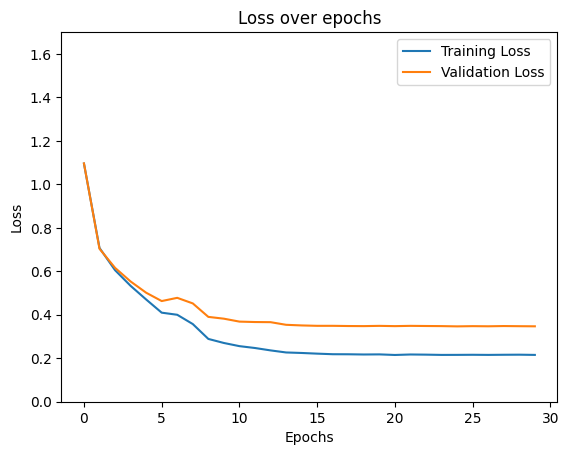

In [97]:
plt.plot(train_losses, label="Training Loss")
plt.plot(valid_losses, label="Validation Loss")
plt.ylim([0, 1.7])
plt.title("Loss over epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();

Also lets plot training and validation accuracy over the epochs.

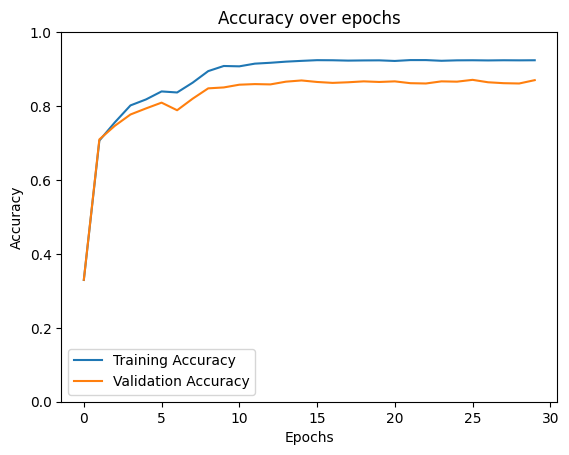

In [98]:
plt.plot(train_accuracies, label="Training Accuracy")
plt.plot(valid_accuracies, label="Validation Accuracy")
plt.ylim([0, 1])
plt.title("Accuracy over epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();

As we can see our model has trained pretty well with very low overfitting. So we can say the model has generalised well.

Let's also inspect how the learning rate was changing during training due to the fact that we used a Learning Rate Scheduling Callback.

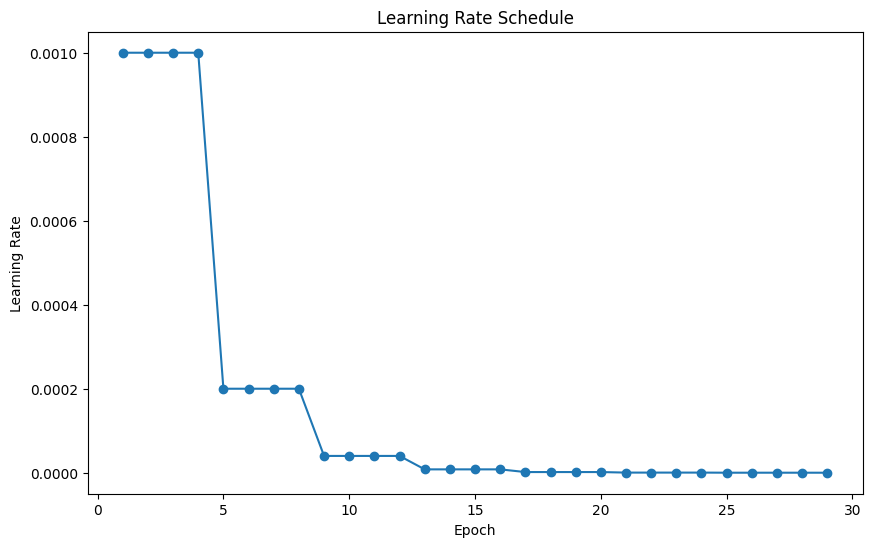

In [99]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), learning_rates, marker="o", label="Learning Rate")
plt.title("Learning Rate Schedule")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.show()

As expected the learning rate has reduced for every 4 epochs.

Now it's time load the best model that we saved with checkpointing!

In [100]:
checkpoint = torch.load(checkpoint_file_path)
# Load the state dictionaries
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

We will use the best model to calculate predictions and evaluate on the testing set.

Lets create a predict function which returns the model's predicted probabilities for each class for each image. We can use this function to plot a confusion matrix for our test set and see the performance.

The function takes model, data loader object and device as inputs and returns a tensor of predictions.

In [101]:
def predict(model, data_loader, device="cpu"):
    # This tensor will store all of the predictions.
    all_probs = torch.tensor([]).to(device)

    # We set the model to evaluation mode. This mode is the opposite of
    # train mode we set in the train_epoch function.
    model.eval()

    # Since we're not training, we don't need any gradient calculations.
    # This tells PyTorch not to calculate any gradients, which speeds up
    # some calculations.
    with torch.no_grad():

        # Again, we iterate over the batches in the data loader and feed
        # them into the model for the forward pass.
        for inputs, targets in tqdm(data_loader, desc="Predicting", leave=False):
            inputs = inputs.to(device)
            output = model(inputs)

            # The model produces the logits.  This softmax function turns the
            # logits into probabilities.  These probabilities are concatenated
            # into the `all_probs` tensor.
            probs = F.softmax(output, dim=1)
            all_probs = torch.cat((all_probs, probs), dim=0)

    return all_probs

Here we are getting probabilities for each class for every image in our test dataset.

In [105]:
probabilities_test = predict(model, test_loader, device)

Predicting:   0%|          | 0/19 [00:00<?, ?it/s]

In [106]:
probabilities_test[0]

tensor([0.2109, 0.6439, 0.1452], device='cuda:0')

The sum of the probability for all the classes for an image is 1. We can verify that here.

In [107]:
probabilities_test[0].sum()

tensor(1., device='cuda:0')

Now lets turn the predicted probabilities into prediction labels.

In [108]:
predictions_test = torch.argmax(probabilities_test, dim=1)
print(f"There are the first 10 predictions on our test set: {predictions_test[:10]}")

There are the first 10 predictions on our test set: tensor([1, 1, 2, 0, 0, 1, 0, 1, 1, 1], device='cuda:0')


Lets get the true labels of our test dataset.

In [109]:
true_test = torch.cat([labels for _, labels in test_loader]).to(device)
print(f"There are the first 10 true labels of our test set: {predictions_test[:10]}")

There are the first 10 true labels of our test set: tensor([1, 1, 2, 0, 0, 1, 0, 1, 1, 1], device='cuda:0')


Now Lets create a Confusion matrix using the true labels and the predicted labels of our model for test data.

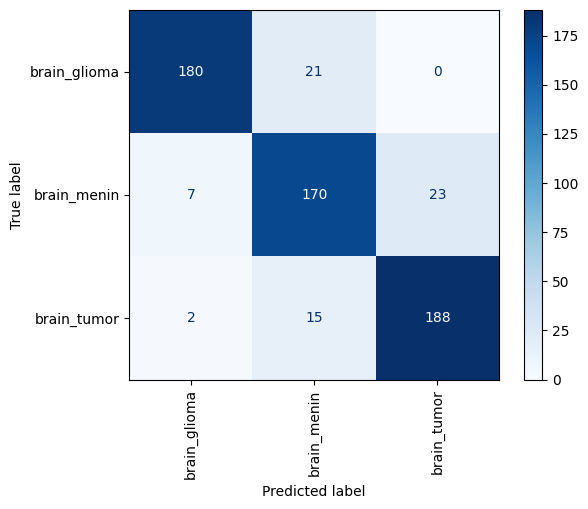

In [110]:
cm = confusion_matrix(true_test.cpu(), predictions_test.cpu())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['brain_glioma', 'brain_menin', 'brain_tumor'])

disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical");

Also Lets calcuate the accuracy for the test set

In [111]:
correct_predictions = np.trace(cm)
total_samples = np.sum(cm)

accuracy = correct_predictions / total_samples
print(f"Accuracy calculated from Confusion Matrix: {accuracy:.4f}")

Accuracy calculated from Confusion Matrix: 0.8878


The models accuracy on the test set is around 0.88.

Now lets train our model on the aumented dataset. Lets create our augmented train data. validation and test data will be normal as before

In [112]:
aug_train_set, val_set, test_set = subset_dataset(data_dir, 0.7, 0.2, 0.1, data_augmentation=True)

Lets Check the class counts of the new subsets

In [114]:
class_counts(aug_train_set, class_to_idx_mapping)

brain_glioma    4206
brain_menin     4209
brain_tumor     4299
dtype: int64

In [115]:
class_counts(val_set, class_to_idx_mapping)


Counting classes:   0%|          | 0/1212 [00:00<?, ?it/s]

brain_glioma    401
brain_menin     401
brain_tumor     410
dtype: int64

In [116]:
class_counts(test_set, class_to_idx_mapping)

Counting classes:   0%|          | 0/606 [00:00<?, ?it/s]

brain_glioma    201
brain_menin     200
brain_tumor     205
dtype: int64

As we can see our training set has lot more data now.

Now lets create the dataloaders

In [117]:
g = torch.Generator().manual_seed(42)

batch_size = 32

train_loader = DataLoader(aug_train_set, batch_size=batch_size, shuffle=True, generator=g, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, generator=g, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, generator=g, pin_memory=True)

We will use same loss function, optimizer and as before. But learning rate scheduler step to 5

In [125]:
step_size = 5
gamma = 0.2

scheduler = optim.lr_scheduler.StepLR(
    optimizer,
    step_size=step_size,
    gamma=gamma,
)

We will use the same model but now on the augmented training data. We will train our new model for 100 epochs. Lets see if the model performance improves or not.

In [126]:
epochs_to_train = 100

In [130]:
train_results = train(
    model,
    optimizer,
    loss_fn,
    train_loader,
    val_loader,
    epochs=epochs_to_train,
    device=device,
    scheduler=scheduler,
    checkpoint_path=checkpoint_file_path,
    early_stopping=early_stopping,
)

(
    learning_rates,
    train_losses,
    valid_losses,
    train_accuracies,
    valid_accuracies,
    epochs,
) = train_results

Model evaluation before start of training...


Scoring:   0%|          | 0/398 [00:00<?, ?it/s]

Training loss before Training: 0.3540
Training accuracy before Training: 86.3222%


Scoring:   0%|          | 0/38 [00:00<?, ?it/s]

Validation loss before Training: 0.3528
Validation accuracy before Training: 86.2664%


Starting epoch 1/100


Training:   0%|          | 0/398 [00:00<?, ?it/s]

Scoring:   0%|          | 0/398 [00:00<?, ?it/s]

Scoring:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 1
Training loss: 0.3541
Training accuracy: 86.2830%
Validation loss: 0.3523
Validation accuracy: 86.5954%
Checkpoint saved with validation loss 0.3523


Starting epoch 2/100


Training:   0%|          | 0/398 [00:00<?, ?it/s]

Scoring:   0%|          | 0/398 [00:00<?, ?it/s]

Scoring:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 2
Training loss: 0.3532
Training accuracy: 86.7384%
Validation loss: 0.3515
Validation accuracy: 86.1842%
Checkpoint saved with validation loss 0.3515


Starting epoch 3/100


Training:   0%|          | 0/398 [00:00<?, ?it/s]

Scoring:   0%|          | 0/398 [00:00<?, ?it/s]

Scoring:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 3
Training loss: 0.3514
Training accuracy: 86.5421%
Validation loss: 0.3508
Validation accuracy: 86.5954%
Checkpoint saved with validation loss 0.3508


Starting epoch 4/100


Training:   0%|          | 0/398 [00:00<?, ?it/s]

Scoring:   0%|          | 0/398 [00:00<?, ?it/s]

Scoring:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 4
Training loss: 0.3546
Training accuracy: 86.4479%
Validation loss: 0.3576
Validation accuracy: 86.1020%


Starting epoch 5/100


Training:   0%|          | 0/398 [00:00<?, ?it/s]

Scoring:   0%|          | 0/398 [00:00<?, ?it/s]

Scoring:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 5
Training loss: 0.3537
Training accuracy: 86.4243%
Validation loss: 0.3511
Validation accuracy: 86.2664%


Starting epoch 6/100


Training:   0%|          | 0/398 [00:00<?, ?it/s]

Scoring:   0%|          | 0/398 [00:00<?, ?it/s]

Scoring:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 6
Training loss: 0.3514
Training accuracy: 86.4793%
Validation loss: 0.3517
Validation accuracy: 86.0197%


Starting epoch 7/100


Training:   0%|          | 0/398 [00:00<?, ?it/s]

Scoring:   0%|          | 0/398 [00:00<?, ?it/s]

Scoring:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 7
Training loss: 0.3532
Training accuracy: 86.0553%
Validation loss: 0.3532
Validation accuracy: 86.3487%


Starting epoch 8/100


Training:   0%|          | 0/398 [00:00<?, ?it/s]

Scoring:   0%|          | 0/398 [00:00<?, ?it/s]

Scoring:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 8
Training loss: 0.3509
Training accuracy: 86.5499%
Validation loss: 0.3529
Validation accuracy: 86.0197%
Early stopping triggered after 8 epochs


Lets plot loss and accuracy curvs

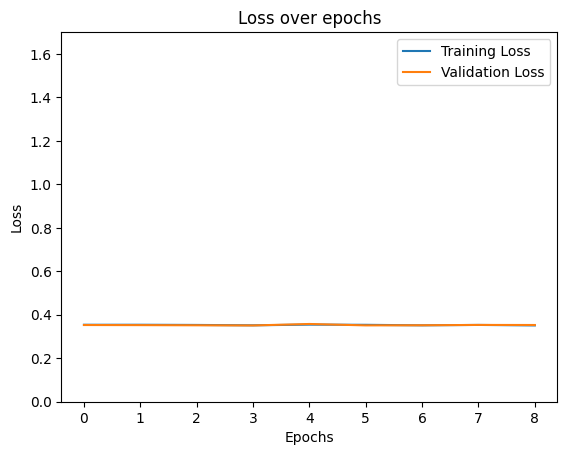

In [131]:
plt.plot(train_losses, label="Training Loss")
plt.plot(valid_losses, label="Validation Loss")
plt.ylim([0, 1.7])
plt.title("Loss over epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();

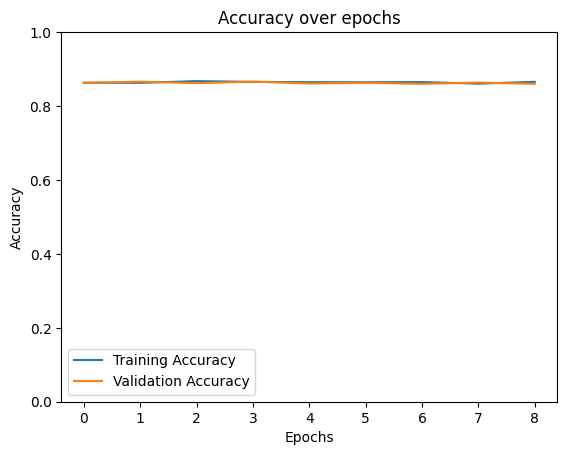

In [132]:
plt.plot(train_accuracies, label="Training Accuracy")
plt.plot(valid_accuracies, label="Validation Accuracy")
plt.ylim([0, 1])
plt.title("Accuracy over epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();

As we can see, though our model has not improved in terms of accuracy, but there is no overfitting like before. So we can say the model has generalised very well.

Lets also plot learning rate change

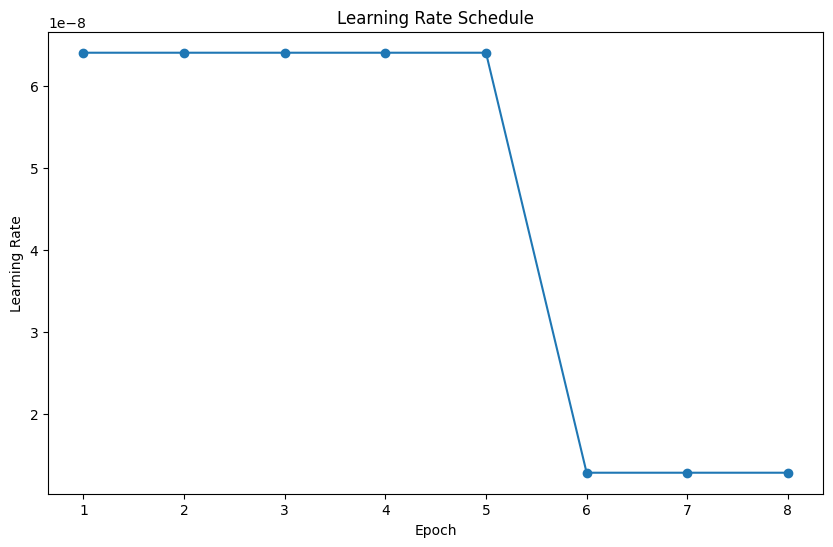

In [133]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), learning_rates, marker="o", label="Learning Rate")
plt.title("Learning Rate Schedule")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.show()

now lets plot confusion matrix on the test set.

Predicting:   0%|          | 0/19 [00:00<?, ?it/s]

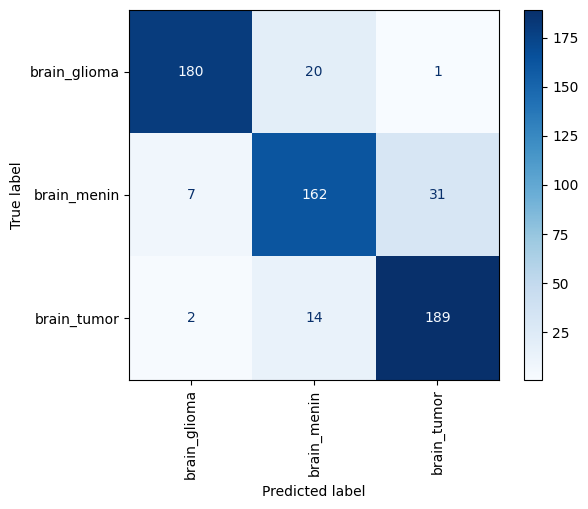

In [134]:
probabilities_test = predict(model, test_loader, device)
predictions_test = torch.argmax(probabilities_test, dim=1)
true_test = torch.cat([labels for _, labels in test_loader]).to(device)

cm = confusion_matrix(true_test.cpu(), predictions_test.cpu())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['brain_glioma', 'brain_menin', 'brain_tumor'])

disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical");

Lets calculate the accuracy on the test set

In [135]:
correct_predictions = np.trace(cm)
total_samples = np.sum(cm)

accuracy = correct_predictions / total_samples
print(f"Accuracy calculated from Confusion Matrix: {accuracy:.4f}")

Accuracy calculated from Confusion Matrix: 0.8762
